### Import Libraries


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from google.colab import drive

### Read csv File

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Projects_shai/Projects data/SalesPrice.csv')

Mounted at /content/drive


### Information about dataFrame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Print 5 Row

In [ ]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### How many columns and rows

In [ ]:
df.shape

(1460, 81)

### Drop duplicates rows


In [ ]:
df.drop_duplicates(inplace=True)

### Check Empty Columns

In [ ]:
df.isnull().sum()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


### Fill null value for numeric columns

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns  # select numeric columns

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())  # fill missing value by mean

### Fill null value for object columns

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns  # select object columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # fill missing value by mode

In [ ]:
df.isnull().sum().head(10)  # Check that the columns are filled in.

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
Alley,0
LotShape,0
LandContour,0
Utilities,0


### Create a ***box plot***  to detect outliers

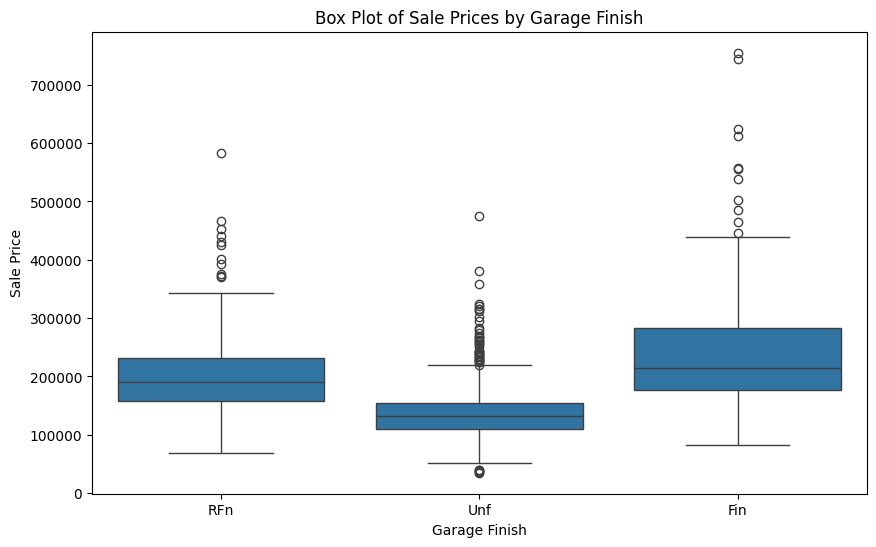

In [ ]:
plt.figure(figsize=(10, 6))

# create Box Plot
sns.boxplot(x='GarageFinish', y='SalePrice', data=df)

plt.title('Box Plot of Sale Prices by Garage Finish')
plt.xlabel('Garage Finish')
plt.ylabel('Sale Price')

# Show plot
plt.show()

### Create **Histogram** to know the distribution

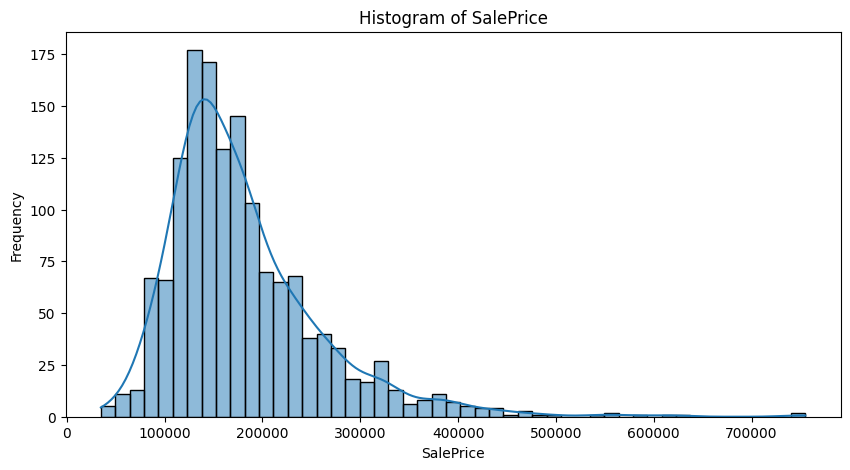

In [ ]:
# Create a histogram
plt.figure(figsize=(10, 5))

sns.histplot(df['SalePrice'], kde=True)
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.show()

### Calculating quarters to find outliers

In [ ]:
Q1 = df['SalePrice'].quantile(0.25)  # calculate Q1 (First quarter)
Q3 = df['SalePrice'].quantile(0.75)  # calculate Q3 (Third quarter)
IQR = Q3 - Q1  # Range quarters

# Outlier detection limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Select outlires
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]

print(f"Number of outliers: {outliers.shape[0]}")
print(outliers[['SalePrice']])

Number of outliers: 61
      SalePrice
11       345000
53       385000
58       438780
112      383970
151      372402
...         ...
1268     381000
1353     410000
1373     466500
1388     377500
1437     394617

[61 rows x 1 columns]


### Apply logaritmic

In [ ]:
# Apply logarithmic transformation to reduce the effect of outliers.
df['SalePrice'] = np.log(df['SalePrice'])

### Create **Histogram** to know the distribution after reduce outliers

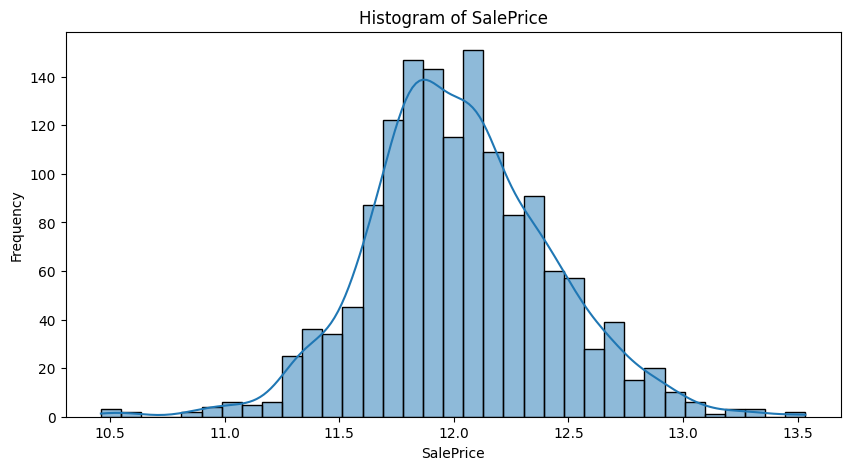

In [ ]:
# Create a histogram
plt.figure(figsize=(10, 5))

sns.histplot(df['SalePrice'], kde=True)
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.show()

### Conducting an ANOVA test

In [ ]:
# selcet categories
fin_prices = df[df['GarageFinish'] == 'Fin']['SalePrice']
rf_prices = df[df['GarageFinish'] == 'RFn']['SalePrice']
unf_prices = df[df['GarageFinish'] == 'Unf']['SalePrice']

# Perform ANOVA test
anova_stat, p_value = f_oneway(fin_prices, rf_prices, unf_prices)

# Print the results
print(f"ANOVA F-statistic: {anova_stat}, p-value: {p_value}")

# Check for statistically significant differences
alpha = 0.05  # Significance level

if p_value < alpha:
    print("There is a statistically significant difference between the mean prices for GarageFinish categories.")
else:
    print("There is no statistically significant difference between the mean prices for GarageFinish categories.")


ANOVA F-statistic: 389.17767538988164, p-value: 3.8133418022809055e-136
There is a statistically significant difference between the mean prices for GarageFinish categories.


### Tukey test

In [ ]:
df_tukey = pd.DataFrame({
    'SalePrice': pd.concat([fin_prices, rf_prices, unf_prices]),
    'GarageFinish': ['Fin'] * len(fin_prices) + ['RFn'] * len(rf_prices) + ['Unf'] * len(unf_prices)
})

# Perform Tukey's HSD
tukey_results = pairwise_tukeyhsd(endog=df_tukey['SalePrice'], groups=df_tukey['GarageFinish'], alpha=0.05)

# print result Tukey
print(tukey_results) 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   Fin    RFn  -0.1481   0.0 -0.2028 -0.0935   True
   Fin    Unf  -0.5405   0.0 -0.5901 -0.4908   True
   RFn    Unf  -0.3923   0.0 -0.4392 -0.3455   True
---------------------------------------------------


### LinearRegression Model

In [ ]:
X = df.drop(columns=['SalePrice'])  # input fetures
y = df['SalePrice']  # Goal feature

# One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Tranning Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Prediction on test set
y_pred = linear_model.predict(X_test)

# calculate R^2
r2 = r2_score(y_test, y_pred)

# print results
print(f"R^2 score: {r2}")

R^2 score: 0.7565402152772933


### Decision Tree Model

In [ ]:
X = df.drop(columns=['SalePrice'])  # input features
y = df['SalePrice']  # Goal feature

# One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Tranning Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Prediction on test set
y_pred = tree_model.predict(X_test)

# calculate R^2
r2 = r2_score(y_test, y_pred)

# print results
print(f"R^2 score: {r2}")

R^2 score: 0.7970331403650683
